In [130]:
import pandas as pd
from dtaidistance import dtw_ndim
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pyreadr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram

In [ ]:
df = pd.read_csv('vitals_trajectory_imputed_no_unimputable.csv')

In [ ]:
df

In [ ]:
# record row index and event hour of died patient, which should be removed from traj_arr
death_info=df[df['event_hour']>df['died_hour_round']][['EncID','event_hour']]
death_encid_index = [df['EncID'].unique().tolist().index(i) for i in death_info['EncID'].tolist()]
death_info['encid_index'] = death_encid_index
to_remove = death_info.sort_values(['encid_index','event_hour']).groupby('encid_index').first()

In [ ]:
to_remove

In [ ]:
# [[feature1_time1, feature2_time1, feature3_time1], [feature1_time2, feature2_time2, feature3_time2], ...]
traj_arr = np.reshape(np.array(df[["MAPImputed","PULSEImputed","RESP_RATEImputed",
                                   "SBPImputed","SF_RATIOImputed","TEMPImputed"]]), 
                      (df['EncID'].nunique(),df['event_hour'].nunique(),6))
traj_arr.shape

In [ ]:
traj_list = traj_arr.copy().tolist()
for idx,hr in zip(to_remove.index.tolist(),to_remove['event_hour'].tolist()):
    traj_i_updated = np.delete(traj_list[idx],np.s_[hr:13], axis = 0)
    traj_list[idx] = traj_i_updated.tolist()
    print(to_remove.loc[idx]['EncID'],len(traj_list[idx]))

In [ ]:
# before removing na
dtw_ndim.distance(traj_arr[0], traj_arr[52], penalty = 5)

In [ ]:
# after removing na
dtw_ndim.distance(np.array(traj_list[0]), np.array(traj_list[52]), penalty = 5)

In [ ]:
# mt = dtw_ndim.distance_matrix(traj_arr, penalty = 1)
mt = np.zeros((traj_arr.shape[0],traj_arr.shape[0]))
start_time = time.time()
# function for dtw matrix
for i in range(traj_arr.shape[0]):
    j = i + 1
    #with open ('dtw_prog.txt', 'a') as f:
        #f.write(str(i))
        #f.write('\n')
    #f.close()
    print(round(time.time()-start_time,2), 'init: ', i,j)
    while j < traj_arr.shape[0]:
        dtw = dtw_ndim.distance(np.array(traj_list[i]), np.array(traj_list[j]), penalty = 5)
        mt[i,j] = dtw
        mt[j,i] = dtw
        j+= 1
        #print('loop', i,j)

In [ ]:
#pd.DataFrame(mt).to_csv('dtw_out.csv',index=False)
pyreadr.write_rds("dtw_out.Rds", pd.DataFrame(mt))

In [ ]:
# check dtw output
sns.heatmap(mt)

/tmp/ipykernel_18317/2934518700.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = shc.linkage(mt,


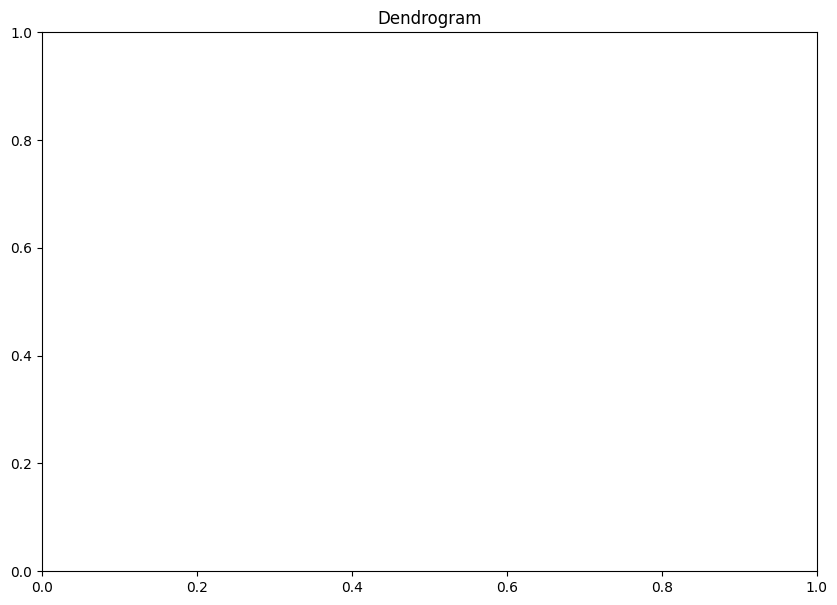

In [133]:
# scipy hac
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
clusters = shc.linkage(mt, 
            method='ward', 
            metric="euclidean")
#pd.DataFrame(clusters).to_csv('hac_clusters.csv',index=False)

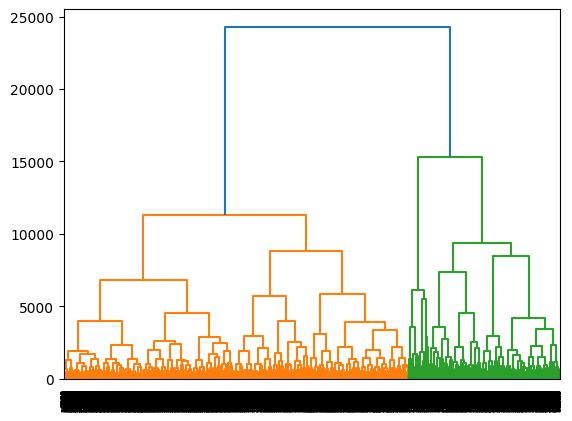

In [134]:
shc.dendrogram(Z=clusters)
plt.show()

In [135]:
# sklearn hac
hac = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
hac_3 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
hac_2 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')

In [136]:
y_hc = hac.fit_predict(mt)
y_hc3 = hac_3.fit_predict(mt)
y_hc2 = hac_2.fit_predict(mt)

/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/ydn4687/.conda/envs/stlearn/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [ ]:
# not specify
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(mt)

In [128]:
# Create linkage matrix for hierarchical clustering
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

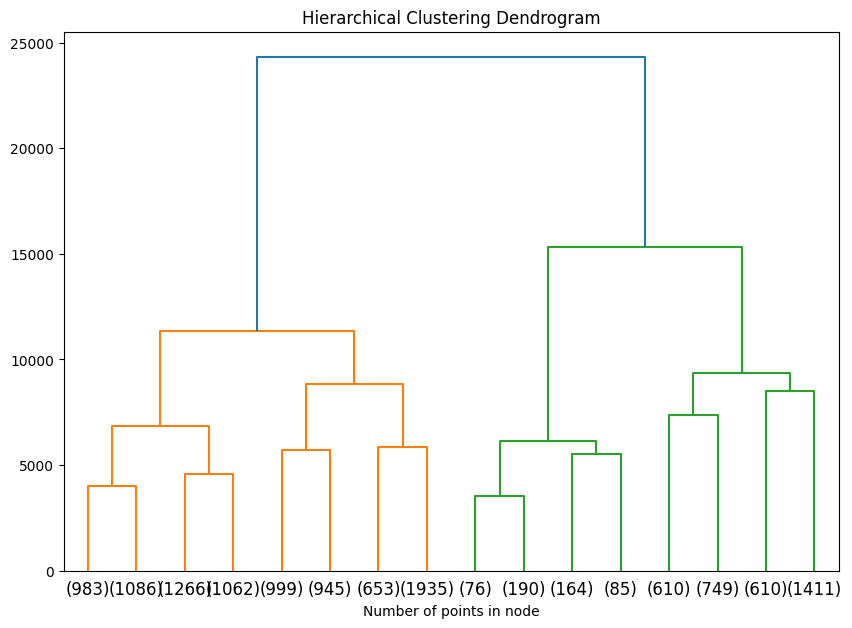

In [131]:
# plot the top three levels of the dendrogram
plt.figure(figsize=(10,7))
plt.xlabel("Number of points in node")
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.show()

In [ ]:
'''
with open(r'hac_label.txt', 'w') as fp:
    for item in y_hc:
        fp.write("%s\n" % item)
    print('Done')
'''

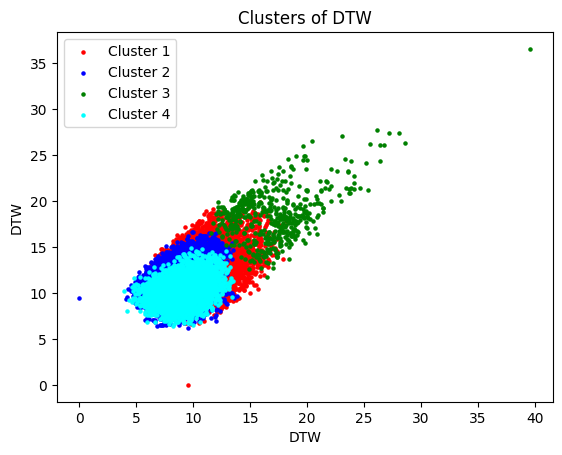

In [137]:
# visualize cluster on raw dtw matrix
plt.scatter(mt[y_hc == 0, 0], mt[y_hc == 0, 1], s = 5, c = 'red', label = 'Cluster 1') # plotting cluster 2
plt.scatter(mt[y_hc == 1, 0], mt[y_hc == 1, 1], s = 5, c = 'blue', label = 'Cluster 2') # plotting cluster 3
plt.scatter(mt[y_hc == 2, 0], mt[y_hc == 2, 1], s = 5, c = 'green', label = 'Cluster 3') # plotting cluster 4
plt.scatter(mt[y_hc == 3, 0], mt[y_hc == 3, 1], s = 5, c = 'cyan', label = 'Cluster 4')  # plotting cluster 5
# plot title addition
plt.title('Clusters of DTW')
# labelling the x-axis
plt.xlabel('DTW')
# label of the y-axis
plt.ylabel('DTW')
# printing the legend
plt.legend()
# show the plot
plt.show()

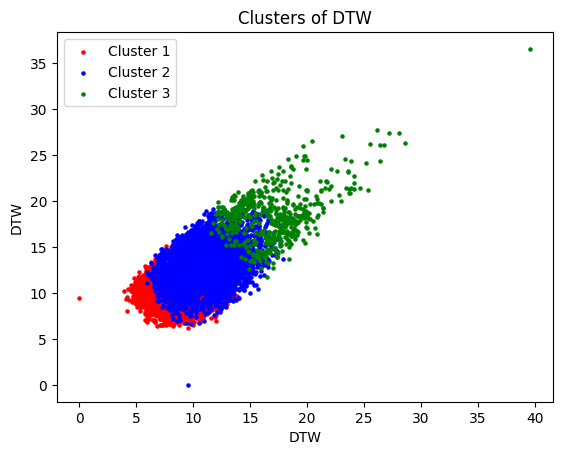

In [138]:
# visualize cluster on raw dtw matrix
plt.scatter(mt[y_hc3 == 0, 0], mt[y_hc3 == 0, 1], s = 5, c = 'red', label = 'Cluster 1') # plotting cluster 2
plt.scatter(mt[y_hc3 == 1, 0], mt[y_hc3 == 1, 1], s = 5, c = 'blue', label = 'Cluster 2') # plotting cluster 3
plt.scatter(mt[y_hc3 == 2, 0], mt[y_hc3 == 2, 1], s = 5, c = 'green', label = 'Cluster 3') # plotting cluster 4
# plot title addition
plt.title('Clusters of DTW')
# labelling the x-axis
plt.xlabel('DTW')
# label of the y-axis
plt.ylabel('DTW')
# printing the legend
plt.legend()
# show the plot
plt.show()

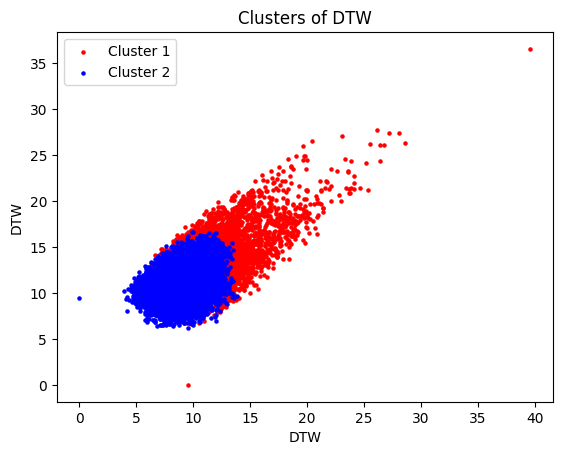

In [143]:
# visualize cluster on raw dtw matrix, RERUN
plt.scatter(mt[y_hc2 == 0, 0], mt[y_hc2 == 0, 1], s = 5, c = 'red', label = 'Cluster 1') # plotting cluster 2
plt.scatter(mt[y_hc2 == 1, 0], mt[y_hc2 == 1, 1], s = 5, c = 'blue', label = 'Cluster 2') # plotting cluster 3
# plot title addition
plt.title('Clusters of DTW')
# labelling the x-axis
plt.xlabel('DTW')
# label of the y-axis
plt.ylabel('DTW')
# printing the legend
plt.legend()
# show the plot
plt.show()

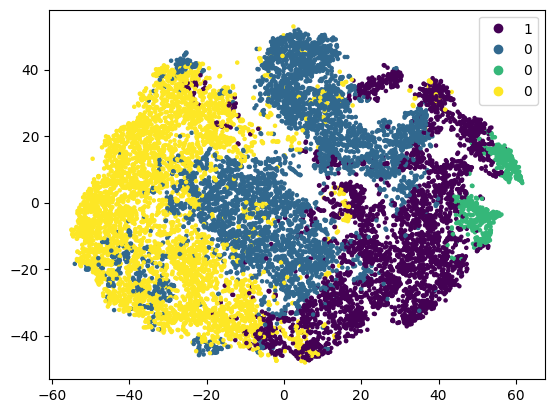

In [140]:
# tsne with cluster label
tsne = TSNE(perplexity = 100)
Xt = tsne.fit_transform(mt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_hc, s= 5)
plt.legend(handles=plot.legend_elements()[0], labels=list(y_hc))
plt.show()

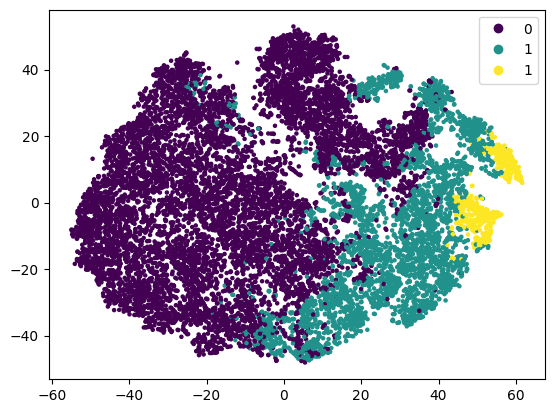

In [141]:
# tsne with cluster label
tsne = TSNE(perplexity = 100)
Xt = tsne.fit_transform(mt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_hc3, s= 5)
plt.legend(handles=plot.legend_elements()[0], labels=list(y_hc3))
plt.show()

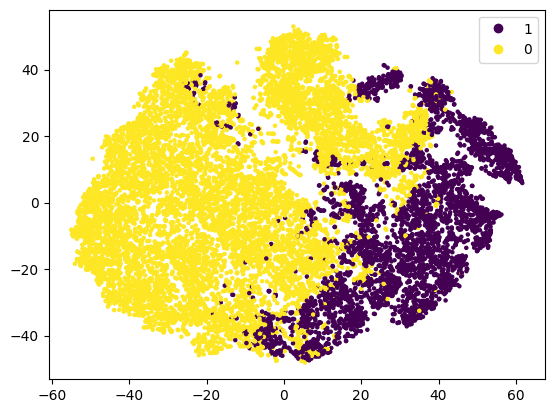

In [142]:
# tsne with cluster label
tsne = TSNE(perplexity = 100)
Xt = tsne.fit_transform(mt)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_hc2, s= 5)
plt.legend(handles=plot.legend_elements()[0], labels=list(y_hc2))
plt.show()

In [ ]:
# add label to dataframe
y_hc_rep = np.repeat(y_hc,13)
print(len(y_hc_rep))
df['cluster_label'] = y_hc_rep.tolist()

In [ ]:
df.groupby(['EncID']).first()['cluster_label'].value_counts()

In [ ]:
df.to_csv('vitals_trajectory_cluster_label.csv',index='False')

In [ ]:
pd.DataFrame(mt).isnull().values.any()